## Prepare the Exprimental Setup 

In [2]:
import h5py
import numpy as np


# Load the dataset
file_path = "/Users/hajarbelmoudden/Downloads/gist-960-euclidean.hdf5" 

with h5py.File(file_path, "r") as f:
    train_data = f["train"][:]  # 1M training points
    test_data = f["test"][:]  # 1k test queries
    
    ground_truth = f["neighbors"][:]  # Ground truth neighbors

In [2]:
train_data


array([[0.0459, 0.0439, 0.0251, ..., 0.0429, 0.0458, 0.0461],
       [0.0375, 0.03  , 0.0332, ..., 0.1033, 0.0573, 0.0492],
       [0.0271, 0.0554, 0.0304, ..., 0.0834, 0.0994, 0.0606],
       ...,
       [0.1123, 0.1982, 0.0926, ..., 0.0896, 0.1517, 0.0805],
       [0.0937, 0.0916, 0.1564, ..., 0.0234, 0.0281, 0.0257],
       [0.0665, 0.0653, 0.0283, ..., 0.0342, 0.049 , 0.0416]],
      dtype=float32)

In [4]:
ground_truth

array([[786559, 624520, 726827, ..., 562022, 809944, 230737],
       [330653, 347044, 427635, ..., 649520, 719420, 152063],
       [242301, 857055, 314243, ..., 369126, 928097, 156056],
       ...,
       [840425, 541921, 862113, ..., 452884, 719686, 968676],
       [652404, 200948, 292290, ..., 188524, 254418, 866825],
       [782118, 294437, 294406, ..., 768540, 934346, 909246]], dtype=int32)

In [5]:
train_data.shape[1]  

960

## Standard K-d Tree Implementation



In [173]:
import numpy as np
import heapq

class KDTreeNode:
    def __init__(self, key, discr, left=None, right=None):
        """
        A node in the KDTree.
        :param key: The k-dimensional point.
        :param discr: The splitting axis (discriminant).
        :param left: Left child.
        :param right: Right child.
        """
        self.key = key
        self.discr = discr
        self.left = left
        self.right = right

class KDTree:
    def __init__(self, k):
        """
        Initialize an empty KDTree.
        :param k: Number of dimensions.
        """
        self.k = k
        self.root = None

    def insert(self, node, point, depth=0):
        """
        Insert a point into the KDTree.
        :param node: Current node in the tree.
        :param point: The k-dimensional point to insert.
        :param depth: Current depth in the tree.
        :return: Updated node after insertion.
        """
        if node is None:
            return KDTreeNode(point, depth % self.k)  # Create new node with current discriminant

        # Determine axis for splitting
        axis = node.discr
        if point[axis] < node.key[axis]:
            # Insert into the left subtree
            node.left = self.insert(node.left, point, depth + 1)
        else:
            # Insert into the right subtree
            node.right = self.insert(node.right, point, depth + 1)

        return node

    def search(self, node, point):
        """
        Search for a point in the KDTree.
        :param node: Current node in the tree.
        :param point: The k-dimensional point to search for.
        :return: True if found, False otherwise.
        """
        if node is None:
            return False  # Not found

        if np.array_equal(node.key, point):
            return True  # Found the point

        # Determine axis for splitting
        axis = node.discr
        if point[axis] < node.key[axis]:
            return self.search(node.left, point)
        else:
            return self.search(node.right, point)

    def insert_point(self, point):
        """
        Public method to insert a point into the KDTree.
        """
        self.root = self.insert(self.root, point)

    def search_point(self, point):
        """
        Public method to search for a point in the KDTree.
        """
        return self.search(self.root, point)
    
    
    def get_clusters(self, min_depth=3):
        """
        Group points into clusters based on proximity (subtree depth threshold).
        :param min_depth: Minimum depth to stop forming clusters.
        :return: List of clusters, where each cluster is a list of points.
        """
        clusters = []

        def collect_points(node):
            """Recursively collect all points in a subtree."""
            if node is None:
                return []
            points = [node.key]
            points.extend(collect_points(node.left))
            points.extend(collect_points(node.right))
            return points

        def traverse(node, depth):
            """Traverse the tree and form clusters based on depth."""
            if node is None:
                return
            # Form a cluster if we reach the threshold depth
            if depth >= min_depth:
                clusters.append(collect_points(node))
            else:
                traverse(node.left, depth + 1)
                traverse(node.right, depth + 1)

        traverse(self.root, 0)
        print(f"Clusters formed: {len(clusters)}")
        return clusters
    


In [174]:
# Build the KDTree with a smaller dataset
kd_tree = KDTree(train_data.shape[1])
for point in train_data:  # Use a subset for testing
    kd_tree.insert_point(point)

# Get clusters with a minimum depth threshold
clusters = kd_tree.get_clusters(min_depth=2)  # Adjust min_depth as needed
print(f"Number of clusters: {len(clusters)}")

# Optional: Print cluster sizes
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} points")

Clusters formed: 4
Number of clusters: 4
Cluster 0: 118506 points
Cluster 1: 276441 points
Cluster 2: 5733 points
Cluster 3: 599317 points


### Visualization of clusters

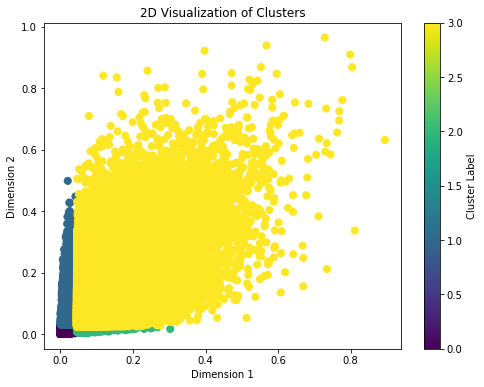

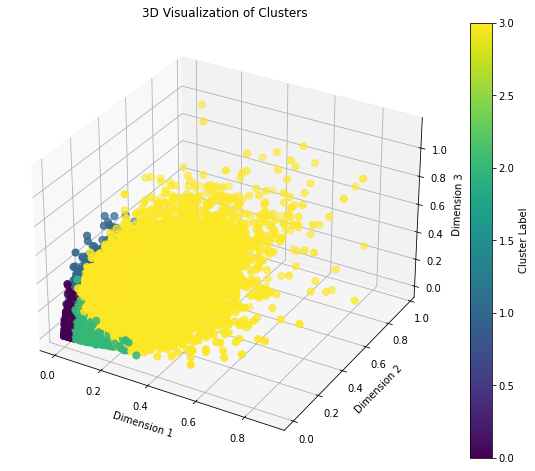

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert clusters to a flat list of points with their cluster labels
points = []
labels = []
for i, cluster in enumerate(clusters):
    for point in cluster:
        points.append(point)
        labels.append(i)

points = np.array(points)

# 2D Visualization
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='viridis', s=50)
plt.title("2D Visualization of Clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label="Cluster Label")
plt.show()

# Optional: 3D Visualization if data has at least 3 dimensions
if points.shape[1] >= 3:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=labels, cmap='viridis', s=50)
    ax.set_title("3D Visualization of Clusters")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    plt.colorbar(scatter, label="Cluster Label")
    plt.show()

Clusters formed: 8
Clusters formed: 8
Clusters formed: 8
Clusters formed: 8
Clusters formed: 8
Clusters formed: 8


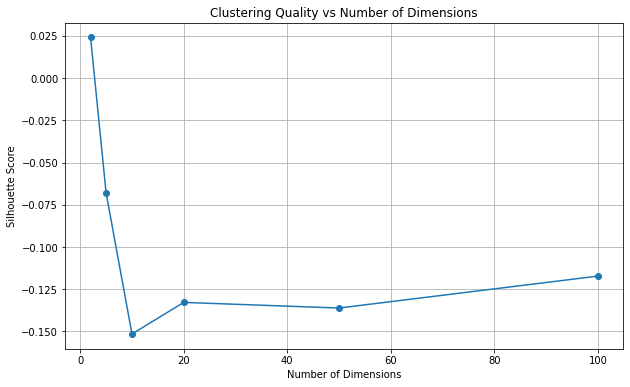

In [153]:
# Evaluate clustering quality for varying dimensions
dimensions = [2, 5, 10, 20, 50, 100]  # Adjust as needed
silhouette_scores = []

for dim in dimensions:
    # Take the first 'dim' dimensions of the data
    data_subset = train_data[:, :dim]
    
    # Build the KDTree
    kd_tree = KDTree(dim)
    for point in data_subset[:1000]:  # Use 1,000 points for clustering
        kd_tree.insert_point(point)
    
    # Get clusters
    clusters = kd_tree.get_clusters(min_depth=3)
    cluster_labels = []
    points = []
    
    # Assign cluster IDs
    for cluster_id, cluster_points in enumerate(clusters):
        for p in cluster_points:
            cluster_labels.append(cluster_id)
            points.append(p)
    
    points = np.array(points)
    cluster_labels = np.array(cluster_labels)
    
    # Calculate Silhouette Score if there are >1 clusters
    if len(np.unique(cluster_labels)) > 1:
        score = silhouette_score(points, cluster_labels)
    else:
        score = 0  # No meaningful score if only one cluster
    silhouette_scores.append(score)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(dimensions, silhouette_scores, marker="o")
plt.title("Clustering Quality vs Number of Dimensions")
plt.xlabel("Number of Dimensions")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

### Evaluate Clustering Quality


In [66]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Dictionary to store clustering quality metrics
metrics_dict = {}

# Use a smaller dataset slice for testing
data_subset = train_data[:1000]  # Adjust the slice size as needed

# Build the KDTree
kd_tree = KDTree(data_subset.shape[1])
for point in data_subset:
    kd_tree.insert_point(point)

# Get clusters with a minimum depth threshold
clusters = kd_tree.get_clusters(min_depth=3)  # Adjust min_depth as needed
print(f"Number of clusters: {len(clusters)}")

# Optional: Print cluster sizes
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} points")

# Create a mapping of points to cluster indices
point_to_cluster = {}
for cluster_idx, cluster in enumerate(clusters):
    for point in cluster:
        point_to_cluster[tuple(np.round(point, decimals=5))] = cluster_idx  # Round points for consistency

# Generate labels that align with the data_subset
labels = []
for point in data_subset:
    rounded_point = tuple(np.round(point, decimals=5))  # Round points for consistency
    if rounded_point in point_to_cluster:
        labels.append(point_to_cluster[rounded_point])
    else:
        print(f"Point not found in clusters: {rounded_point}")
        labels.append(-1)  # Assign an outlier label if the point is not found

# Filter outliers (if any)
filtered_data = [point for point, label in zip(data_subset, labels) if label != -1]
filtered_labels = [label for label in labels if label != -1]

# Ensure labels match the number of points in the subset after filtering
assert len(filtered_labels) == len(filtered_data), "Mismatch between labels and filtered data size!"

# Evaluate clustering quality
silhouette = silhouette_score(filtered_data, filtered_labels)
calinski = calinski_harabasz_score(filtered_data, filtered_labels)
davies = davies_bouldin_score(filtered_data, filtered_labels)

# Store metrics in the dictionary
metrics_dict["KDTree"] = {
    "Silhouette Score": silhouette,
    "Calinski-Harabasz Index": calinski,
    "Davies-Bouldin Index": davies,
}

# Display clustering quality metrics
print("\nClustering Quality Metrics:")
print(f"Silhouette Score: {silhouette:.4f} (higher is better)")
print(f"Calinski-Harabasz Index: {calinski:.4f} (higher is better)")
print(f"Davies-Bouldin Index: {davies:.4f} (lower is better)")

# Print metrics dictionary
print("\nMetrics Dictionary:")
print(metrics_dict)

Clusters formed: 8
Number of clusters: 8
Cluster 0: 66 points
Cluster 1: 22 points
Cluster 2: 30 points
Cluster 3: 252 points
Cluster 4: 1 points
Cluster 5: 3 points
Cluster 6: 565 points
Cluster 7: 54 points
Point not found in clusters: (0.0459, 0.0439, 0.0251, 0.0318, 0.0159, 0.0564, 0.0335, 0.0273, 0.0156, 0.0627, 0.0504, 0.0116, 0.0289, 0.0432, 0.0388, 0.0282, 0.0405, 0.0417, 0.0309, 0.0338, 0.0165, 0.0291, 0.0245, 0.0208, 0.0207, 0.0727, 0.0386, 0.0145, 0.0347, 0.0462, 0.0238, 0.0333, 0.0616, 0.0418, 0.0344, 0.0448, 0.0221, 0.0348, 0.0275, 0.0319, 0.0445, 0.1036, 0.0365, 0.0168, 0.0539, 0.0554, 0.0224, 0.0432, 0.1612, 0.0764, 0.0892, 0.1059, 0.0974, 0.057, 0.064, 0.072, 0.1108, 0.1132, 0.0399, 0.035, 0.0914, 0.0654, 0.0676, 0.0481, 0.2254, 0.0976, 0.1954, 0.1424, 0.1787, 0.0932, 0.0989, 0.0909, 0.1794, 0.0632, 0.104, 0.0889, 0.1972, 0.0874, 0.1693, 0.1058, 0.0982, 0.0606, 0.1163, 0.0678, 0.0728, 0.065, 0.029, 0.0384, 0.0692, 0.0409, 0.0631, 0.0669, 0.1183, 0.0573, 0.0792, 0.1229, 

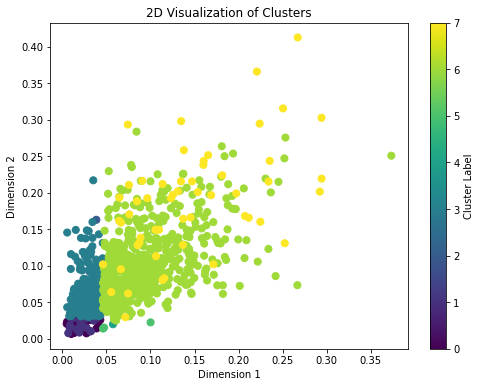

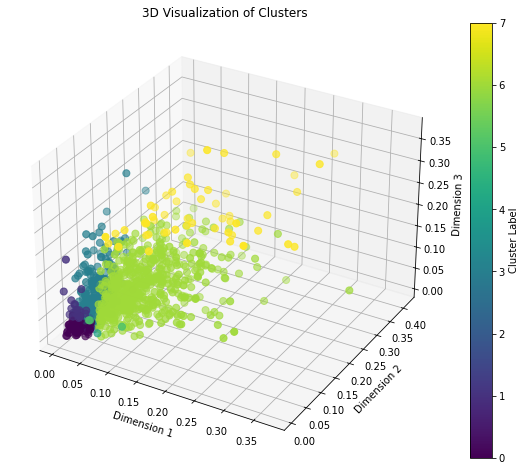

In [80]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert clusters to a flat list of points with their cluster labels
points = []
labels = []
for i, cluster in enumerate(clusters):
    for point in cluster:
        points.append(point)
        labels.append(i)

points = np.array(points)

# 2D Visualization
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='viridis', s=50)
plt.title("2D Visualization of Clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label="Cluster Label")
plt.show()

# Optional: 3D Visualization if data has at least 3 dimensions
if points.shape[1] >= 3:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=labels, cmap='viridis', s=50)
    ax.set_title("3D Visualization of Clusters")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    plt.colorbar(scatter, label="Cluster Label")
    plt.show()

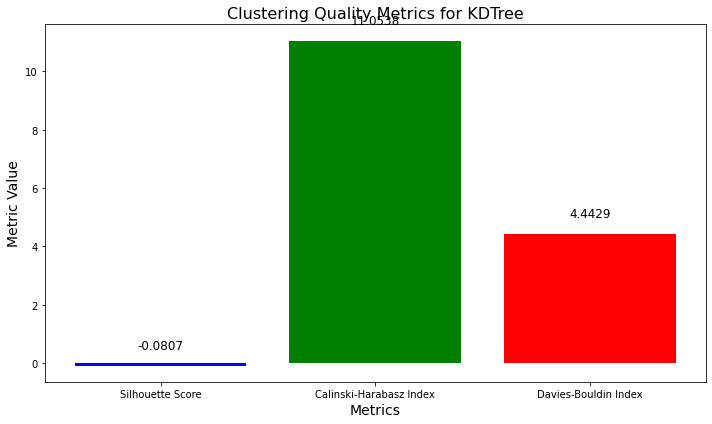

In [79]:
import matplotlib.pyplot as plt

# Example values (replace with actual metric results)
metrics = metrics_dict['KDTree']

# Bar plot for clustering quality metrics
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'green', 'red']
ax.bar(metrics.keys(), metrics.values(), color=colors)

# Add titles and labels
ax.set_title("Clustering Quality Metrics for KDTree", fontsize=16)
ax.set_ylabel("Metric Value", fontsize=14)
ax.set_xlabel("Metrics", fontsize=14)

# Annotate bar values
for i, (key, value) in enumerate(metrics.items()):
    ax.text(i, value + (max(metrics.values()) * 0.05), f"{value:.4f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

### Clustering Quality vs Number of Dimensions

Clusters formed: 8
Clusters formed: 8
Clusters formed: 8
Clusters formed: 8
Clusters formed: 8
Clusters formed: 8
Clusters formed: 8
Clusters formed: 8


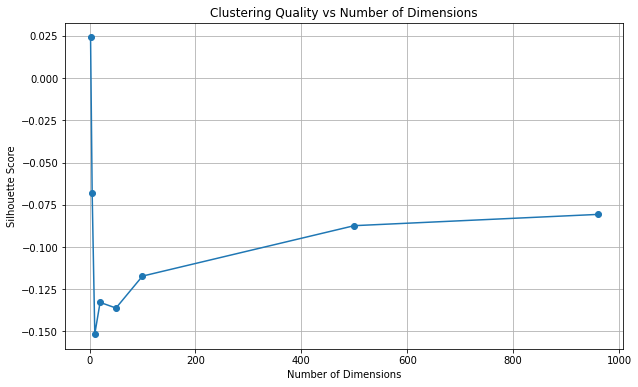

In [ ]:

# Evaluate clustering quality for varying dimensions
dimensions = [2, 5, 10, 20, 50, 100, 500,960]  # Adjust as needed
silhouette_scores = []

for dim in dimensions:
    # Take the first 'dim' dimensions of the data
    data_subset = train_data[:, :dim]
    
    # Build the KDTree
    kd_tree = KDTree(dim)
    for point in data_subset[:1000]:  # Use 1,000 points for clustering
        kd_tree.insert_point(point)
    
    # Get clusters
    clusters = kd_tree.get_clusters(min_depth=3)
    cluster_labels = []
    points = []
    
    # Assign cluster IDs
    for cluster_id, cluster_points in enumerate(clusters):
        for p in cluster_points:
            cluster_labels.append(cluster_id)
            points.append(p)
    
    points = np.array(points)
    cluster_labels = np.array(cluster_labels)
    
    # Calculate Silhouette Score if there are >1 clusters
    if len(np.unique(cluster_labels)) > 1:
        score = silhouette_score(points, cluster_labels)
    else:
        score = 0  # No meaningful score if only one cluster
    silhouette_scores.append(score)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(dimensions, silhouette_scores, marker="o")
plt.title("Clustering Quality vs Number of Dimensions")
plt.xlabel("Number of Dimensions")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


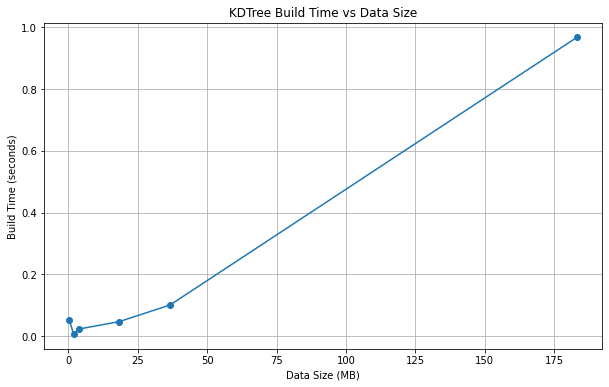

In [124]:
import time 
# Parameters
data_sizes = [100, 500, 1000, 5000, 10000, 50000]  # Number of points to test
build_times = []
storage_sizes = []

# Measure time to build index for each size
for num_points in data_sizes:
    data_subset = train_data[:num_points, :]  # Use 'num_points' from the data
    
    # Measure size in MB
    storage_size = data_subset.nbytes / (1024 * 1024)  # Convert bytes to MB
    storage_sizes.append(storage_size)
    
    # Measure build time
    start_time = time.time()
    kd_tree = KDTree(data_subset.shape[1])  # Initialize KDTree
    for point in data_subset:
        kd_tree.insert_point(point)  # Insert points into KDTree
    end_time = time.time()
    
    build_time = end_time - start_time
    build_times.append(build_time)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(storage_sizes, build_times, marker="o")
plt.title("KDTree Build Time vs Data Size")
plt.xlabel("Data Size (MB)")
plt.ylabel("Build Time (seconds)")
plt.grid(True)
plt.show()

## KD Tree Variants Implementation


### 1. Squarish k-d Tree Construction 


In [128]:
import random
class SquarishKDTreeNode:
    def __init__(self, point, discr, region, left=None, right=None):
        """
        A node in the Squarish KDTree.
        :param point: The k-dimensional point.
        :param discr: The splitting axis (discriminant).
        :param region: The bounding region [l0, u0] x [l1, u1] x ... x [lk-1, uk-1].
        :param left: Left child.
        :param right: Right child.
        """
        self.point = point  # The k-dimensional point stored in the node
        self.discr = discr  # Splitting axis
        self.region = region  # Bounding region
        self.left = left  # Left subtree
        self.right = right  # Right subtree


class SquarishKDTree:
    def __init__(self, k):
        """
        Initialize an empty Squarish KDTree.
        :param k: Number of dimensions.
        """
        self.k = k  # Number of dimensions
        self.root = None  # Root node of the tree

    def get_longest_side(self, region):
        """
        Find the dimension corresponding to the longest side of the region.
        :param region: The region [l0, u0] x [l1, u1] x ... x [lk-1, uk-1].
        :return: Index of the longest dimension.
        """
        lengths = [region[1][i] - region[0][i] for i in range(self.k)]
        max_length = max(lengths)
        candidates = [i for i in range(self.k) if lengths[i] == max_length]
        return random.choice(candidates)  # Break ties randomly

    def insert(self, node, point, region, depth=0):
        """
        Insert a point into the Squarish KDTree recursively.
        :param node: Current node in the tree.
        :param point: The k-dimensional point to insert.
        :param region: The region of the current node.
        :param depth: Current depth in the tree.
        :return: Updated node after insertion.
        """
        if node is None:
            discr = self.get_longest_side(region)
            return SquarishKDTreeNode(point, discr, region)

        # Determine axis for splitting
        axis = node.discr

        # Update the region for the left or right child
        left_region = [region[0][:], region[1][:]]
        right_region = [region[0][:], region[1][:]]
        if point[axis] < node.point[axis]:
            left_region[1][axis] = node.point[axis]  # Update upper bound
            node.left = self.insert(node.left, point, left_region, depth + 1)
        else:
            right_region[0][axis] = node.point[axis]  # Update lower bound
            node.right = self.insert(node.right, point, right_region, depth + 1)

        return node

    def search(self, node, point):
        """
        Search for a point in the Squarish KDTree.
        :param node: Current node in the tree.
        :param point: The k-dimensional point to search for.
        :return: True if the point is found, False otherwise.
        """
        if node is None:
            return False

        if np.array_equal(node.point, point):
            return True

        # Determine axis for splitting
        axis = node.discr
        if point[axis] < node.point[axis]:
            return self.search(node.left, point)
        else:
            return self.search(node.right, point)

    def insert_point(self, point):
        """
        Public method to insert a point into the Squarish KDTree.
        :param point: The k-dimensional point to insert.
        """
        if self.root is None:
            # Initialize root with full space
            region = [[-np.inf] * self.k, [np.inf] * self.k]
            self.root = self.insert(self.root, point, region)
        else:
            self.root = self.insert(self.root, point, self.root.region)

    def search_point(self, point):
        """
        Public method to search for a point in the Squarish KDTree.
        :param point: The k-dimensional point to search for.
        :return: True if the point is found, False otherwise.
        """
        return self.search(self.root, point)
    



### 2.  Relaxed kd-Tree

In [105]:
import numpy as np
import random


class RelaxedKDTreeNode:
    def __init__(self, point, discr, left=None, right=None):
        """
        A node in the Relaxed KDTree.
        :param point: The k-dimensional point.
        :param discr: The splitting axis (discriminant).
        :param left: Left child.
        :param right: Right child.
        """
        self.point = point  # The k-dimensional point stored in the node
        self.discr = discr  # Randomly chosen splitting axis
        self.left = left  # Left subtree
        self.right = right  # Right subtree


class RelaxedKDTree:
    def __init__(self, k):
        """
        Initialize an empty Relaxed KDTree.
        :param k: Number of dimensions.
        """
        self.k = k  # Number of dimensions
        self.root = None  # Root node of the tree

    def insert(self, node, point):
        """
        Insert a point into the Relaxed KDTree recursively.
        :param node: Current node in the tree.
        :param point: The k-dimensional point to insert.
        :return: Updated node after insertion.
        """
        if node is None:
            discr = random.randint(0, self.k - 1)  # Randomly choose the discriminant
            return RelaxedKDTreeNode(point, discr)

        # Determine axis for splitting
        axis = node.discr
        if point[axis] < node.point[axis]:
            node.left = self.insert(node.left, point)
        else:
            node.right = self.insert(node.right, point)

        return node

    def search(self, node, point):
        """
        Search for a point in the Relaxed KDTree.
        :param node: Current node in the tree.
        :param point: The k-dimensional point to search for.
        :return: True if the point is found, False otherwise.
        """
        if node is None:
            return False

        if np.array_equal(node.point, point):
            return True

        # Determine axis for splitting
        axis = node.discr
        if point[axis] < node.point[axis]:
            return self.search(node.left, point)
        else:
            return self.search(node.right, point)

    def insert_point(self, point):
        """
        Public method to insert a point into the Relaxed KDTree.
        """
        self.root = self.insert(self.root, point)

    def search_point(self, point):
        """
        Public method to search for a point in the Relaxed KDTree.
        """
        return self.search(self.root, point)
    
    def get_clusters(self):
        """
        Traverse the Relaxed KDTree and group points into clusters based on subtrees.
        :return: List of clusters, where each cluster is a list of points.
        """
        clusters = []

        def traverse_and_collect(node):
            if node is None:
                return []
            cluster = []
            stack = [node]
            while stack:
                current = stack.pop()
                if current:
                    cluster.append(current.point)
                    if current.left:
                        stack.append(current.left)
                    if current.right:
                        stack.append(current.right)
            return cluster

        def collect_clusters(node):
            if node is None:
                return
            clusters.append(traverse_and_collect(node))
            collect_clusters(node.left)
            collect_clusters(node.right)

        collect_clusters(self.root)
        return clusters
    

### 3. Median kd-tree

In [106]:
import numpy as np

class MedianKDTreeNode:
    def __init__(self, point, discr, left=None, right=None):
        """
        A node in the Median KDTree.
        :param point: The k-dimensional point.
        :param discr: The splitting axis (discriminant).
        :param left: Left child.
        :param right: Right child.
        """
        self.point = point  # The k-dimensional point stored in the node
        self.discr = discr  # The splitting dimension
        self.left = left  # Left subtree
        self.right = right  # Right subtree


class MedianKDTree:
    def __init__(self, k):
        """
        Initialize an empty Median KDTree.
        :param k: Number of dimensions.
        """
        self.k = k  # Number of dimensions
        self.root = None  # Root node of the tree

    def _find_median(self, points, axis):
        """
        Find the median point along a specified axis.
        :param points: List of k-dimensional points.
        :param axis: The axis to find the median along.
        :return: The median point and its index.
        """
        points_sorted = sorted(points, key=lambda x: x[axis])
        median_idx = len(points_sorted) // 2
        return points_sorted[median_idx], median_idx

    def _choose_discriminant(self, bounding_box, point):
        """
        Choose the discriminant dimension based on the formal definition.
        :param bounding_box: Current bounding box [l, u] for each dimension.
        :param point: The point being inserted.
        :return: The chosen discriminant dimension.
        """
        k = len(bounding_box)
        differences = [
            abs((point[i] - bounding_box[i][0]) / (bounding_box[i][1] - bounding_box[i][0]) - 0.5)
            for i in range(k)
        ]
        return np.argmin(differences)

    def build(self, points, bounding_box=None, depth=0):
        """
        Build the Median KDTree from a list of points.
        :param points: List of k-dimensional points.
        :param bounding_box: Bounding box of the current region.
        :param depth: Current depth in the tree.
        :return: Root node of the constructed tree.
        """
        if not points:
            return None

        if bounding_box is None:
            bounding_box = [[float('-inf'), float('inf')] for _ in range(self.k)]

        # Choose the discriminant based on the bounding box
        discr = self._choose_discriminant(bounding_box, points[0])

        # Find the median along the chosen axis
        points.sort(key=lambda x: x[discr])
        median_idx = len(points) // 2
        median_point = points[median_idx]

        # Update the bounding box for children
        left_bounding_box = [list(b) for b in bounding_box]
        right_bounding_box = [list(b) for b in bounding_box]
        left_bounding_box[discr][1] = median_point[discr]
        right_bounding_box[discr][0] = median_point[discr]

        # Create the tree node and recursively build subtrees
        return MedianKDTreeNode(
            point=median_point,
            discr=discr,
            left=self.build(points[:median_idx], left_bounding_box, depth + 1),
            right=self.build(points[median_idx + 1:], right_bounding_box, depth + 1),
        )

    def insert_point(self, point):
        """
        Insert a point into the Median KDTree.
        """
        if self.root is None:
            self.root = self.build([point])
        else:
            self.root = self._insert(self.root, point, depth=0)


    def _insert(self, node, point, depth):
        """
        Recursive insertion for the Median KDTree.
        :param node: Current node in the tree.
        :param point: The point to insert.
        :param depth: Current depth in the tree.
        :return: Updated node after insertion.
        """
        if node is None:
            discr = depth % self.k
            return MedianKDTreeNode(point, discr)

        axis = node.discr
        if point[axis] < node.point[axis]:
            node.left = self._insert(node.left, point, depth + 1)
        else:
            node.right = self._insert(node.right, point, depth + 1)

        return node
    
    
    
    
    
    def get_clusters(self):
        """
        Traverse the Median KDTree and group points into clusters based on subtrees.
        :return: List of clusters, where each cluster is a list of points.
        """
        clusters = []

        def traverse_and_collect(node):
            if node is None:
                return []
            cluster = []
            stack = [node]
            while stack:
                current = stack.pop()
                if current:
                    cluster.append(current.point)
                    if current.left:
                        stack.append(current.left)
                    if current.right:
                        stack.append(current.right)
            return cluster

        def collect_clusters(node):
            if node is None:
                return
            clusters.append(traverse_and_collect(node))
            collect_clusters(node.left)
            collect_clusters(node.right)

        collect_clusters(self.root)
        return clusters
    

## Define Tree Construction Metrics

### Evaluate Time of building index 

In [175]:
import time

# Evaluate KDTree construction
def evaluate_tree_construction(tree_class, train_data):
    k = train_data.shape[1]  # Number of dimensions
    tree = tree_class(k)  # Initialize the tree

    print(f"Building {tree_class.__name__} with training data...")
    start_time = time.time()
    for point in train_data:
        tree.insert_point(point)
    construction_time = time.time() - start_time
    print(f"{tree_class.__name__} construction completed in {construction_time:.2f} seconds.")
    
    return tree, construction_time

In [9]:
# Define tree classes
tree_classes = [KDTree, SquarishKDTree,MedianKDTree, RelaxedKDTree]

# Dictionary to store results
construction_results = {}

# Loop through each tree class
for tree_class in tree_classes:
    tree, time_taken = evaluate_tree_construction(tree_class, train_data)
    construction_results[tree_class.__name__] = time_taken

# Display results
print("\nTree Construction Times:")
for tree_name, time_taken in construction_results.items():
    print(f"{tree_name}: {time_taken:.2f} seconds.")

Building KDTree with training data...
KDTree construction completed in 39.70 seconds.
Building SquarishKDTree with training data...
SquarishKDTree construction completed in 1333.26 seconds.
Building MedianKDTree with training data...


/var/folders/rh/nxnz_hy10752g7ls2rz1mfx00000gn/T/ipykernel_1627/1616036875.py:47: RuntimeWarning: invalid value encountered in scalar divide
  abs((point[i] - bounding_box[i][0]) / (bounding_box[i][1] - bounding_box[i][0]) - 0.5)


MedianKDTree construction completed in 344.49 seconds.
Building RelaxedKDTree with training data...
RelaxedKDTree construction completed in 64.98 seconds.

Tree Construction Times:
KDTree: 39.70 seconds.
SquarishKDTree: 1333.26 seconds.
MedianKDTree: 344.49 seconds.
RelaxedKDTree: 64.98 seconds.


In [12]:
construction_results

{'KDTree': 39.697726249694824,
 'SquarishKDTree': 1333.2558207511902,
 'MedianKDTree': 344.49439787864685,
 'RelaxedKDTree': 64.98187685012817}

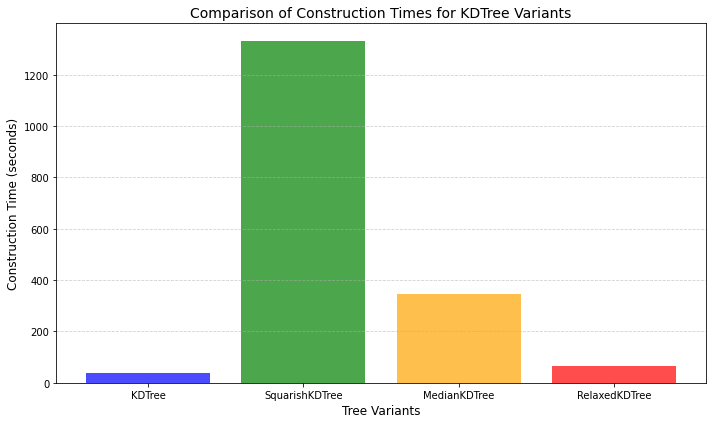

In [13]:
import matplotlib.pyplot as plt


# Extract tree names and construction times
tree_names = list(construction_results.keys())
construction_times = list(construction_results.values())

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(tree_names, construction_times, color=['blue', 'green', 'orange', 'red'], alpha=0.7)

# Adding labels, title, and grid
plt.xlabel("Tree Variants", fontsize=12)
plt.ylabel("Construction Time (seconds)", fontsize=12)
plt.title("Comparison of Construction Times for KDTree Variants", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

### 1. Standard K-d tree

Use the clustering metrics (Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Index) to evaluate the quality of clusters.

### Nearest Neighbor Search


In [5]:
# Perform nearest neighbor search
query_point = test_data[0]  # Example: first test query
ground_truth_point = train_data[ground_truth[0, 0]]  # Expected nearest neighbor

# Measure nearest neighbor search time
start_time = time.time()
nearest_point = kd_tree.find_nearest(query_point)
search_time = time.time() - start_time

# Check if the nearest point matches the ground truth
is_correct_nn = np.array_equal(nearest_point, ground_truth_point)

# Print results
print("\nNearest Neighbor Search:")
print(f"Query Point: {query_point}")
print(f"Nearest Point Found: {nearest_point}")

print(f"Ground Truth Nearest Point: {ground_truth_point}")
print(f"Search Time: {search_time:.6f} seconds")
print(f"Nearest Neighbor Correct: {is_correct_nn}")



Nearest Neighbor Search:
Query Point: [0.0117 0.0115 0.0087 0.01   0.0785 0.1    0.0784 0.053  0.0524 0.0819
 0.0658 0.058  0.0159 0.017  0.0461 0.0242 0.0084 0.0064 0.0072 0.0102
 0.0304 0.0679 0.0589 0.0571 0.0333 0.0786 0.0892 0.0423 0.0138 0.0133
 0.029  0.0219 0.009  0.0122 0.0107 0.0108 0.0266 0.0385 0.0571 0.052
 0.0355 0.0488 0.0692 0.0531 0.0144 0.0143 0.0149 0.025  0.0171 0.0161
 0.0106 0.0324 0.0271 0.0458 0.0531 0.0624 0.0316 0.0608 0.0661 0.0813
 0.0186 0.0227 0.0116 0.0337 0.0247 0.0118 0.0107 0.0639 0.0395 0.0403
 0.0525 0.0958 0.0551 0.0676 0.0858 0.1749 0.0244 0.0281 0.0087 0.0512
 0.0149 0.0086 0.0124 0.0356 0.0328 0.0387 0.0463 0.0489 0.0492 0.0641
 0.0705 0.1164 0.0206 0.0162 0.0125 0.0402 0.0135 0.0113 0.0074 0.0118
 0.033  0.0298 0.0365 0.042  0.0441 0.0519 0.0659 0.0527 0.0139 0.0162
 0.0151 0.0224 0.0118 0.0088 0.0078 0.0109 0.0373 0.0705 0.0628 0.0391
 0.0242 0.0558 0.0721 0.0448 0.0168 0.0134 0.0331 0.0208 0.0041 0.009
 0.0165 0.0117 0.0962 0.1359 0.1215 0.08

## 	1.	Exact Matching:


•	The current search_point function checks for exact matches (point equality).

	•	In high-dimensional datasets like yours, exact matches are rare due to the sparsity of points in the space.

In [10]:
# Step 2: Search for test points in KD-Tree
print("Searching for test points in KD-Tree...")
start_time = time.time()

search_results = []
for query in test_data:
    found = kd_tree.search_point(query)  # Check if the query point exists in the tree
    search_results.append(found)

search_time = time.time() - start_time
print(f"Search completed in {search_time:.2f} seconds for {len(test_data)} queries.")

Searching for test points in KD-Tree...
Search completed in 0.33 seconds for 1000 queries.


In [11]:
# Step 3: Summarize Results
found_count = sum(search_results)
print(f"{found_count} out of {len(test_data)} test points were found in the KD-Tree.")

15 out of 1000 test points were found in the KD-Tree.


In [12]:
# Step 3: Summarize Results and Calculate Accuracy
found_count = sum(search_results)
accuracy = (found_count / len(test_data)) * 100  # Accuracy as a percentage

print(f"{found_count} out of {len(test_data)} test points were found in the KD-Tree.")
print(f"Accuracy of exact matching: {accuracy:.2f}%")

15 out of 1000 test points were found in the KD-Tree.
Accuracy of exact matching: 1.50%


The result of “15 out of 1000 test points were found in the KD-Tree” indicates that only 1.5% of your test points have an exact match in the training data stored in the KD-Tree. This result is expected because:


## Nearest Neighbor Search

In [15]:
print("Performing nearest neighbor search...")
start_time = time.time()

nearest_results = []
for query in test_data[:100]:  # Limit for faster testing
    nearest_neighbor = kd_tree.find_nearest(query)
    nearest_results.append(nearest_neighbor)

search_time = time.time() - start_time
print(f"Nearest neighbor search completed in {search_time:.2f} seconds for 100 queries.")

Performing nearest neighbor search...
Nearest neighbor search completed in 2099.73 seconds for 100 queries.


In [25]:

# Calculate Accuracy
correct_matches = 0

for i, query in enumerate(test_data[:100]):  # Compare first 100 queries
    ground_truth_neighbors = ground_truth[i]  # Ground truth indices
    nearest_found = nearest_results[i]  # Nearest neighbor from KD-tree

    # Check if nearest neighbor matches any ground truth neighbor
    if any(np.array_equal(nearest_found, train_data[gt]) for gt in ground_truth_neighbors):
        correct_matches += 1

# Accuracy Calculation
accuracy = (correct_matches / len(test_data[:100])) * 100
print(f"Accuracy of KD-Tree nearest neighbor search: {accuracy:.2f}%")

Accuracy of KD-Tree nearest neighbor search: 100.00%


In [28]:
# Initialize the count for correct matches
correct_matches = 0

# Compare each query's result with its ground truth neighbors
for i in range(len(nearest_results)):  # Iterate over the test queries
    nearest_found = nearest_results[i]  # Nearest neighbor found by the KD-tree
    ground_truth_neighbors = ground_truth[i]  # Ground truth indices for this query
    
    # Check if the nearest found matches any ground truth neighbor
    if any(np.array_equal(nearest_found, train_data[gt]) for gt in ground_truth_neighbors):
        correct_matches += 1

# Calculate accuracy
accuracy = (correct_matches / len(nearest_results)) * 100

# Print the results
print(f"Accuracy of KD-Tree nearest neighbor search: {accuracy:.2f}%")

Accuracy of KD-Tree nearest neighbor search: 100.00%


## Standard K-d tree implementation

In [5]:
class KDTreeNode:
    def __init__(self, key, discr, left=None, right=None):
        """
        A node in the KDTree.
        :param key: The k-dimensional point.
        :param discr: The splitting axis (discriminant).
        :param left: Left child.
        :param right: Right child.
        """
        self.key = key
        self.discr = discr
        self.left = left
        self.right = right


class KDTree:
    def __init__(self, k):
        """
        Initialize an empty KDTree.
        :param k: Number of dimensions.
        """
        self.k = k
        self.root = None



    def insert(self, node, point, depth=0):
        """
        Insert a point into the KDTree.
        :param node: Current node in the tree.
        :param point: The k-dimensional point to insert.
        :param depth: Current depth in the tree.
        :return: Updated node after insertion.
        """
        if node is None:
            return KDTreeNode(point, depth % self.k)  # Create new node with current discriminant

        # Determine axis for splitting
        axis = node.discr
        if point[axis] < node.key[axis]:
            # Insert into the left subtree
            node.left = self.insert(node.left, point, depth + 1)
        else:
            # Insert into the right subtree
            node.right = self.insert(node.right, point, depth + 1)

        return node

    def search(self, node, point):
        """
        Search for a point in the KDTree.
        :param node: Current node in the tree.
        :param point: The k-dimensional point to search for.
        :return: True if found, False otherwise.
        """
        if node is None:
            return False  # Not found

        if np.array_equal(node.key, point):
            return True  # Found the point

        # Determine axis for splitting
        axis = node.discr
        if point[axis] < node.key[axis]:
            return self.search(node.left, point)
        else:
            return self.search(node.right, point)

    def insert_point(self, point):
        """
        Public method to insert a point into the KDTree.
        """
        self.root = self.insert(self.root, point)

    def search_point(self, point):
        """
        Public method to search for a point in the KDTree.
        """
        return self.search(self.root, point)
    
    
    def nearest_neighbor(self, node, target, depth=0, best=None):
        if node is None:
            return best

        # Update the best point
        current_distance = np.linalg.norm(node.key - target)
        if best is None or current_distance < np.linalg.norm(best.key - target):
            best = node

        # Determine which subtree to search
        axis = depth % self.k
        if target[axis] < node.key[axis]:
            best = self.nearest_neighbor(node.left, target, depth + 1, best)
            if abs(target[axis] - node.key[axis]) < np.linalg.norm(best.key - target):
                best = self.nearest_neighbor(node.right, target, depth + 1, best)
        else:
            best = self.nearest_neighbor(node.right, target, depth + 1, best)
            if abs(target[axis] - node.key[axis]) < np.linalg.norm(best.key - target):
                best = self.nearest_neighbor(node.left, target, depth + 1, best)

        return best

    def find_nearest(self, target):
        nearest_node = self.nearest_neighbor(self.root, target)
        return nearest_node.key if nearest_node else None    

In [8]:
# Perform nearest neighbor search
query_point = test_data[0]  # Example: first test query
ground_truth_point = train_data[ground_truth[0, 0]]  # Expected nearest neighbor

# Measure nearest neighbor search time
start_time = time.time()
nearest_point = kd_tree.find_nearest(query_point)
search_time = time.time() - start_time

# Check if the nearest point matches the ground truth
is_correct_nn = np.array_equal(nearest_point, ground_truth_point)

# Print results
print("\nNearest Neighbor Search:")
print(f"Query Point: {query_point}")
print(f"Nearest Point Found: {nearest_point}")

print(f"Ground Truth Nearest Point: {ground_truth_point}")
print(f"Search Time: {search_time:.6f} seconds")
print(f"Nearest Neighbor Correct: {is_correct_nn}")


Nearest Neighbor Search:
Query Point: [0.0117 0.0115 0.0087 0.01   0.0785 0.1    0.0784 0.053  0.0524 0.0819
 0.0658 0.058  0.0159 0.017  0.0461 0.0242 0.0084 0.0064 0.0072 0.0102
 0.0304 0.0679 0.0589 0.0571 0.0333 0.0786 0.0892 0.0423 0.0138 0.0133
 0.029  0.0219 0.009  0.0122 0.0107 0.0108 0.0266 0.0385 0.0571 0.052
 0.0355 0.0488 0.0692 0.0531 0.0144 0.0143 0.0149 0.025  0.0171 0.0161
 0.0106 0.0324 0.0271 0.0458 0.0531 0.0624 0.0316 0.0608 0.0661 0.0813
 0.0186 0.0227 0.0116 0.0337 0.0247 0.0118 0.0107 0.0639 0.0395 0.0403
 0.0525 0.0958 0.0551 0.0676 0.0858 0.1749 0.0244 0.0281 0.0087 0.0512
 0.0149 0.0086 0.0124 0.0356 0.0328 0.0387 0.0463 0.0489 0.0492 0.0641
 0.0705 0.1164 0.0206 0.0162 0.0125 0.0402 0.0135 0.0113 0.0074 0.0118
 0.033  0.0298 0.0365 0.042  0.0441 0.0519 0.0659 0.0527 0.0139 0.0162
 0.0151 0.0224 0.0118 0.0088 0.0078 0.0109 0.0373 0.0705 0.0628 0.0391
 0.0242 0.0558 0.0721 0.0448 0.0168 0.0134 0.0331 0.0208 0.0041 0.009
 0.0165 0.0117 0.0962 0.1359 0.1215 0.08

## Clustering Quality Evaluation

## Standard k-d tree exprimentation

### 1. Speed of building the KDTree index

Evaluating KDTree for data size: 1000 points
Evaluating KDTree for data size: 5000 points
Evaluating KDTree for data size: 10000 points
Evaluating KDTree for data size: 20000 points
Evaluating KDTree for data size: 50000 points
Evaluating KDTree for data size: 100000 points


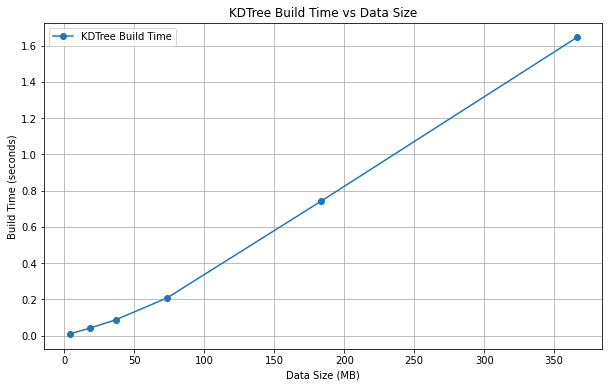

In [129]:
import time
import matplotlib.pyplot as plt
import numpy as np
import h5py

# Parameters
data_sizes = [1000, 5000, 10000, 20000, 50000, 100000]  # Data sizes to test
build_times = []  # Time to build KDTree
storage_sizes = []  # Storage sizes in MB

# Evaluate the build time and storage size for each data size
for size in data_sizes:
    print(f"Evaluating KDTree for data size: {size} points")
    data_subset = train_data[:size]  # Subset the data

    # Measure storage size in MB
    storage_size = data_subset.nbytes / (1024 * 1024)  # Convert bytes to MB
    storage_sizes.append(storage_size)

    # Measure KDTree build time
    kd_tree = KDTree(data_subset.shape[1])  # Initialize KDTree
    start_time = time.time()
    for point in data_subset:
        kd_tree.insert_point(point)
    build_time = time.time() - start_time
    build_times.append(build_time)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(storage_sizes, build_times, marker="o", label="KDTree Build Time")
plt.title("KDTree Build Time vs Data Size")
plt.xlabel("Data Size (MB)")
plt.ylabel("Build Time (seconds)")
plt.grid(True)
plt.legend()
plt.show()

### 2. Quality of clustering (using silhouette score as a metric)

Clusters formed: 8
Clusters formed: 8
Clusters formed: 8
Clusters formed: 8
Clusters formed: 8
Clusters formed: 8


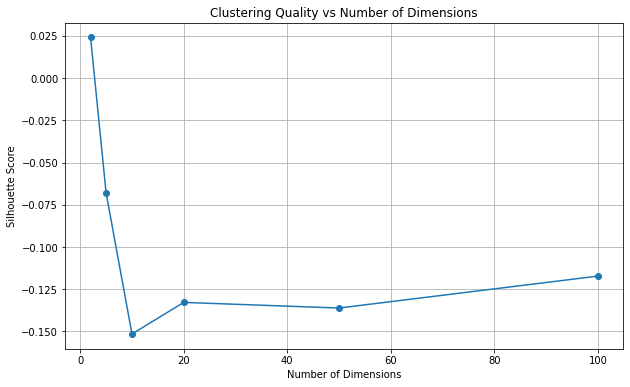

In [137]:
# Evaluate clustering quality for varying dimensions
dimensions = [2, 5, 10, 20, 50, 100]  # Adjust as needed
silhouette_scores = []

for dim in dimensions:
    # Take the first 'dim' dimensions of the data
    data_subset = train_data[:, :dim]
    
    # Build the KDTree
    kd_tree = KDTree(dim)
    for point in data_subset[:1000]:  # Use 1,000 points for clustering
        kd_tree.insert_point(point)
    
    # Get clusters
    clusters = kd_tree.get_clusters(min_depth=3)
    cluster_labels = []
    points = []
    
    # Assign cluster IDs
    for cluster_id, cluster_points in enumerate(clusters):
        for p in cluster_points:
            cluster_labels.append(cluster_id)
            points.append(p)
    
    points = np.array(points)
    cluster_labels = np.array(cluster_labels)
    
    # Calculate Silhouette Score if there are >1 clusters
    if len(np.unique(cluster_labels)) > 1:
        score = silhouette_score(points, cluster_labels)
    else:
        score = 0  # No meaningful score if only one cluster
    silhouette_scores.append(score)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(dimensions, silhouette_scores, marker="o")
plt.title("Clustering Quality vs Number of Dimensions")
plt.xlabel("Number of Dimensions")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

### 3. Index Size vs Data Size

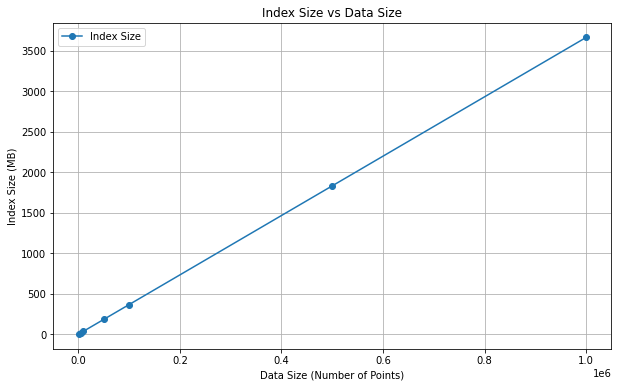

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
data_sizes = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]  # Different dataset sizes to test
dimensions = 960  # Number of dimensions in the dataset
bytes_per_value = 4  # Assuming Float32 (4 bytes per value)
index_sizes = []  # To store the calculated index sizes

# Compute index size for each dataset size
for size in data_sizes:
    index_size = size * dimensions * bytes_per_value  # Total size in bytes
    index_sizes.append(index_size / (1024 * 1024))  # Convert to MB

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, index_sizes, marker="o", label="Index Size")
plt.title("Index Size vs Data Size")
plt.xlabel("Data Size (Number of Points)")
plt.ylabel("Index Size (MB)")
plt.grid(True)
plt.legend()
plt.show()

### 4. Query Speed

Evaluating for leaf size (min_depth): 1
Clusters formed: 2
Evaluating for leaf size (min_depth): 3
Clusters formed: 8
Evaluating for leaf size (min_depth): 5
Clusters formed: 19
Evaluating for leaf size (min_depth): 7
Clusters formed: 47
Evaluating for leaf size (min_depth): 9
Clusters formed: 81
Evaluating for leaf size (min_depth): 11
Clusters formed: 101
Evaluating for leaf size (min_depth): 13
Clusters formed: 98
Evaluating for leaf size (min_depth): 15
Clusters formed: 71
Evaluating for leaf size (min_depth): 17
Clusters formed: 49
Evaluating for leaf size (min_depth): 19
Clusters formed: 19
Evaluating for leaf size (min_depth): 21
Clusters formed: 6
Evaluating for leaf size (min_depth): 23
Clusters formed: 0


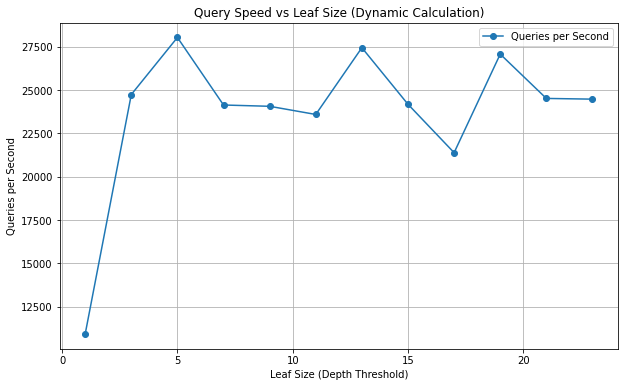

In [138]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Parameters
test_queries = test_data[:100]  # Use a subset of test queries for evaluation
data_subset = train_data[:1000]  # Use a subset of training data for testing
queries_per_second = []  # Store the queries per second results
leaf_sizes = []  # Dynamically calculate leaf sizes (depth thresholds)

# Build the KDTree
kd_tree = KDTree(data_subset.shape[1])
for point in data_subset:
    kd_tree.insert_point(point)

# Dynamically calculate possible leaf sizes based on tree depth
max_depth = 0


def calculate_depth(node, depth=0):
    global max_depth
    if node is None:
        max_depth = max(max_depth, depth)
        return
    calculate_depth(node.left, depth + 1)
    calculate_depth(node.right, depth + 1)


calculate_depth(kd_tree.root)
leaf_sizes = list(range(1, max_depth + 1, max(1, max_depth // 10)))  # Select evenly spaced depths

# Evaluate query speed for different leaf sizes
for leaf_size in leaf_sizes:
    print(f"Evaluating for leaf size (min_depth): {leaf_size}")
    
    # Group clusters based on the leaf size
    clusters = kd_tree.get_clusters(min_depth=leaf_size)
    
    # Measure query speed
    start_time = time.time()
    for query in test_queries:
        kd_tree.search_point(query)  # Perform the search
    elapsed_time = time.time() - start_time
    
    # Calculate queries per second
    qps = len(test_queries) / elapsed_time
    queries_per_second.append(qps)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(leaf_sizes, queries_per_second, marker="o", label="Queries per Second")
plt.title("Query Speed vs Leaf Size (Dynamic Calculation)")
plt.xlabel("Leaf Size (Depth Threshold)")
plt.ylabel("Queries per Second")
plt.grid(True)
plt.legend()
plt.show()